In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
plt.style.use('seaborn')
sns.set_palette('deep')

/var/folders/h0/v4b0bs811x35xjk82g1h9bg00000gn/T/ipykernel_14746/4215720933.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
conn = sqlite3.connect('papcorns.sqlite')
users_df = pd.read_sql_query("SELECT * FROM users;", conn)
events_df = pd.read_sql_query("SELECT * FROM user_events;", conn)

## 1. Revenue by Country

In [4]:
query = """
SELECT
    users.country,
    SUM(user_events.amount_usd) AS total_revenue
FROM
    users
JOIN
    user_events ON users.id = user_events.user_id
GROUP BY
    users.country;
    """
pd.read_sql_query(query, conn)

,country,total_revenue
0,NL,3335.29
1,TR,2275.44
2,US,4035.96


## 2. Number of Trials from Instagram

In [5]:
query = """
SELECT
    user_events.event_name
FROM
    users
JOIN
    user_events ON users.id = user_events.user_id
WHERE
    user_events.event_name = "trial_started" AND
    users.attribution_source = "instagram";
    """
pd.read_sql_query(query, conn)

,event_name
0,trial_started
1,trial_started
2,trial_started
3,trial_started
4,trial_started
...,...
205,trial_started
206,trial_started
207,trial_started
208,trial_started


It is **210**.

## 3. Acquisition Channel

In [6]:
query = """
SELECT *,

    CASE
        WHEN attribution_source = 'organic' THEN 'Organic'
        ELSE 'Paid'
    END AS acquisition_channel
FROM users

"""

pd.read_sql_query(query, conn)

conn.commit()

## 4. Trial-to-Subscription Rate

**(From now on I will use Python libraries for the sake of smoothness: these dummies will be of use later.)**

We need to subset those who initiated their trial to calculate the conversion rate.

In [7]:
users_df = pd.read_sql_query("SELECT * FROM users;", conn)
events_df = pd.read_sql_query("SELECT * FROM user_events;", conn)

# Changing the column names for user id and event creation in the users_df dataset to prevent confusion
# during the merge:

users_df = users_df.rename(columns = {'created_at' : 'account_created', 'id' : 'user_id'})

merged_df = pd.merge(users_df, events_df, on = "user_id")
merged_df

# Now let's create trial dummy to filter out those who did not start a trial:
merged_df['trialer'] = np.where(merged_df['event_name'] == 'trial_started', 1, 0)

#...and another dummy to filter out subscribers:
merged_df['subscriber'] = np.where(merged_df['event_name'] == 'subscription_started', 1, 0)

# Subsetting
trialer = merged_df.groupby('user_id').agg(country = ('country', 'first'),
                                          attribution_source = ('attribution_source', 'first'),
                                          subscriber = ('subscriber', 'sum'),
                                          trialer = ('trialer', 'sum'))
trialer = trialer[trialer['trialer'] == 1]


And the conversion rate is: 

In [8]:
trialer['subscriber'].mean()

0.7052785923753666

...and the breakdown by attribution source would be:

In [9]:
trialer.groupby('attribution_source').agg(conv_rate = ('subscriber', 'mean'))

,conv_rate
attribution_source,
instagram,0.709524
organic,0.716102
tiktok,0.690678


Customers with organic attribution source have a slightly higher trial-to-subscription rate.

## 5. Median Subscription Duration

This is a tricky task since it is not clear if we are interested in a cohort of subscribers or our entire customer base, some of which has never bought subscription. I will do both for the sake of clarity.

### 5.1. For All Customers

I will create two subsets of customers (those who subscribed at least once and those who have not) and merge them together to calculate the average duration per country. For the former, I will subset the events starting from subscription onwards and take number of subscription creation and renewal entries. Subscription duration of the latter will automatically be assigned to 0.

For subscribers:

In [10]:
subscribers = merged_df[(merged_df['event_name'] == 'subscription_started') |
                (merged_df['event_name'] == 'subscription_renewed') |
                (merged_df['event_name'] == 'subscription_cancelled')]

subscribers['renewal'] = np.where(subscribers['event_name'] == 'subscription_renewed', 1, 0)

subscribers = subscribers.groupby('user_id').agg(country = ('country', 'first'),
                                                 attribution_source = ('attribution_source', 'first'),
                                mindate = ('created_at', 'min'),
                                maxdate = ('created_at', 'max'),
                                renewal = ('renewal', 'sum'))

# Creating a column for duration
subscribers['duration'] = (subscribers['renewal'] + 1)

# Excluding min- and maxdate columns for the upcoming merge:
subscribers = subscribers[['country', 'duration', 'attribution_source']]
subscribers

/var/folders/h0/v4b0bs811x35xjk82g1h9bg00000gn/T/ipykernel_14746/1681212960.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers['renewal'] = np.where(subscribers['event_name'] == 'subscription_renewed', 1, 0)


,country,duration,attribution_source
user_id,,,
2,NL,4,instagram
3,TR,4,tiktok
8,TR,2,tiktok
9,US,2,organic
10,US,2,organic
...,...,...,...
992,US,5,instagram
995,US,3,instagram
996,TR,3,organic


and for non-subscribers:

In [11]:
non_subscribers = merged_df.groupby('user_id').agg(subscriber = ('subscriber', 'sum'),
                                                  country = ('country', 'first'),
                                                  attribution_source = ('attribution_source', 'first'),)

non_subscribers = non_subscribers[non_subscribers['subscriber'] == 0]

non_subscribers['duration'] = 0
non_subscribers = non_subscribers[['country', 'attribution_source', 'duration']]

all_customers = pd.concat([non_subscribers, subscribers])

all_customers.groupby('country').agg(avg_duration = ('duration', 'mean'))

,avg_duration
country,
NL,1.204545
TR,1.288136
US,1.188235


### 5.2. For Subscribers

In [12]:
subscribers.groupby('country').agg(avg_duration = ('duration', 'mean'))

,avg_duration
country,
NL,2.489933
TR,2.666667
US,2.509317


## 6. ALT by Country

I will follow a similar strategy here using the previous data frame I constructed. Let's first create a new column in our subscribers dataset corresponding to the payment that each subscription month costs.

In [13]:
conditions = [
    subscribers['country'] == "NL",
    subscribers['country'] == 'US',
    subscribers['country'] == 'TR'
]

choices = [
    8.99,
    9.99,
    4.99
]

subscribers['amount'] = np.select(conditions, choices, default = 'unknown')
subscribers['amount'] = pd.to_numeric(subscribers['amount'])

...and calculate the lifetime value as the multiplication of subscription duration with the amount per month.

In [14]:
subscribers['lifetime_value'] = (subscribers.duration)*(subscribers.amount)

As for the non-subscribers, this value is 0. Thus:

In [15]:
non_subscribers['amount'] = 0
non_subscribers['lifetime_value'] = 0

# Merging data 
all_customers = pd.concat([non_subscribers, subscribers])

all_customers.groupby('country').agg(Average_Lifetime_Value = ('lifetime_value', 'mean'))

,Average_Lifetime_Value
country,
NL,10.828864
TR,6.427797
US,11.870471


## 7. Churn Probability for Clark Kent

Let's exclude Clark Kent from our sample first.

In [16]:
novo = merged_df[merged_df['name'] != 'Clark Kent']

A 'churn' could refer to acts in which a customer does not continue their service or subscription, therefore, we can benefit from a three-stage machine learning process in which Clark's odds of starting a trial (1), proceeding with the subscription (2) and sticking to his subscription (3) are analyzed. 

There is significant variation among the total time that our customers spent at different stages (e.g., downloading the app, starting the trial, ending the trial), yet we only have a single entry for Clark Kent. Moreover, although the price of our subscription service would be equally important, it is fixed based on country, leaving us no variation to factor in. Therefore, country origins and acquisition channel would be the two predictors with which we can train our model. **In the following stage, I will construct a binary classification model with a single outcome variable, *churner*, refering to whether the customer ended up leaving the service.** 

Let's first create an customer-level data including **country origin, acqusition channel, trial status, trial-to-subscription status**, and **ultimate subscription status**. We already have two dummies pertaining to trial and subscription, leaving us with the task of creating a dummy of subscription cancellation.

In [17]:
novo['cancellation'] = np.where(novo['event_name'] == 'subscription_cancelled', 1, 0)
novo_sum = novo.groupby('user_id').agg(country = ('country', 'first'),
                                      attribution_source = ('attribution_source', 'first'),
                                       acquisition_channel = ('acquisition_channel', 'first'),
                                     trial = ('trialer', 'sum'),
                                     subscription = ('subscriber', 'sum'),
                                     cancellation = ('cancellation', 'sum'))

novo_sum['continuation'] = np.where((novo_sum['subscription'] == 1) & (novo_sum['cancellation'] == 0), 1, 0)

/var/folders/h0/v4b0bs811x35xjk82g1h9bg00000gn/T/ipykernel_14746/963360113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novo['cancellation'] = np.where(novo['event_name'] == 'subscription_cancelled', 1, 0)


We can finally create a 'churner' dummy which we will use as the outcome variable:

In [18]:
novo_sum['churner'] = np.where(
    (novo_sum['trial'] == 0) |
    ((novo_sum['trial'] == 1) & (novo_sum['subscription'] == 0)) |
    ((novo_sum['subscription'] == 1) & (novo_sum['continuation'] == 0)),
    1,
    0
)

Constructing our binary classification model based on logistic regression:

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

X = novo_sum[['country', 'attribution_source']]
y = novo_sum['churner']

# Turning our categorical predictors into dummies for the training:
X_encoded = pd.get_dummies(X, drop_first=True)

# Creating our training and test groups:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Subsetting and preparing Mr. Kent's data for prediction

clark_kent = merged_df[merged_df['name'] == 'Clark Kent']
clark_kent = clark_kent[['country', 'attribution_source']]

clark_kent = clark_kent.reindex(columns=X_encoded.columns, fill_value=0)

### Final step: Bootstrapped CIs and predicted probability for Clark Kent

# Set seed for reproducability:
np.random.seed(42)

n_bootstraps = 1000
boot_preds = []

for _ in range(n_bootstraps):
    
    X_resampled = X_train.sample(frac=1, replace=True, random_state=np.random.randint(10000))
    y_resampled = y_train.loc[X_resampled.index]

   
    model_boot = LogisticRegression()
    model_boot.fit(X_resampled, y_resampled)

    
    boot_preds.append(model_boot.predict_proba(clark_kent)[:, 1][0])


lower_bound = np.percentile(boot_preds, 2.5)
upper_bound = np.percentile(boot_preds, 97.5)

churn_probability = model_boot.predict_proba(clark_kent)[:, 1]

Mr. Kent's estimated probability of turning out to be a churner in the end with confidence intervals is:

In [20]:
print(f"Churn Probability: {churn_probability[0]:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

Churn Probability: 0.88
95% Confidence Interval: [0.80, 0.91]


Let's visualize how different observations in two of our predictors affect the likelihood of turning out to be a churner by using the coefficients in our logistic regression baseline:

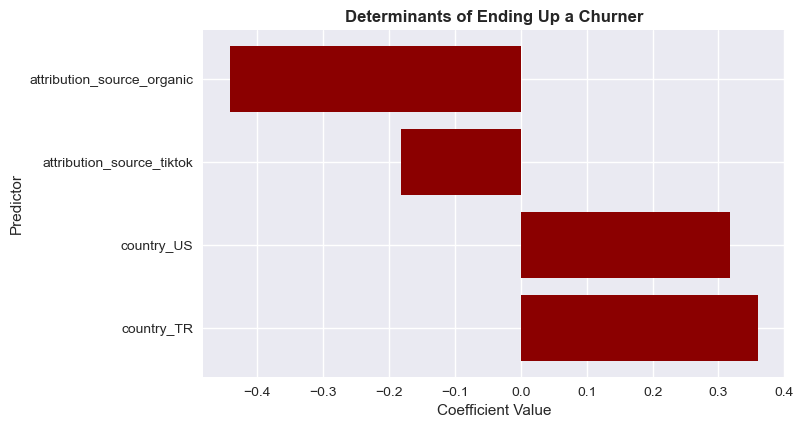

In [21]:
coefficients = model_boot.coef_[0]
predictor_names = X_encoded.columns

coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(7.5, 4.5))
plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color = 'darkred')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.title('Determinants of Ending Up a Churner', fontweight = 'bold')
plt.show()

We see that the Turkish customers are more likely to end up as churners compared to those from the Netherlands or the US, whereas customers whose attribution source is tiktok or organic are less likely to churn compared to those coming from Instagram. Note that Clark Kent is from Turkey and his attribution source is organic.

**However**, this one-step binary classification model alongside others does not tell us much on different pathways to churn: not starting the trial run after downloading the app (1), not subscribing to the paid service after the trial period (2), or cancelling the subscription (3). Therefore, I propose replicate the same analysis for these three distinct stages below.

### 7. A. Download-to-Trial

We already have a 'trial' dummy which we will use as our outcome variable.

In [22]:
novo_sum['no_trial'] = np.where(novo_sum['trial'] == 0, 1, 0)

X = novo_sum[['country', 'attribution_source']]
y = novo_sum['no_trial']

# Turning our categorical predictors into dummies for the training:
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Set seed for reproducability:
np.random.seed(42)

n_bootstraps = 1000
boot_preds = []

for _ in range(n_bootstraps):

    X_resampled = X_train.sample(frac=1, replace=True, random_state=np.random.randint(10000))
    y_resampled = y_train.loc[X_resampled.index]

    
    model_boot = LogisticRegression()
    model_boot.fit(X_resampled, y_resampled)

    
    boot_preds.append(model_boot.predict_proba(clark_kent)[:, 1][0])


lower_bound = np.percentile(boot_preds, 2.5)
upper_bound = np.percentile(boot_preds, 97.5)

no_trial_probability = model_boot.predict_proba(clark_kent)[:, 1]

Making Mr. Kent's probability of not starting the trial:

In [23]:
print(f"No Trial Probability: {no_trial_probability[0]:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

No Trial Probability: 0.24
95% Confidence Interval: [0.20, 0.34]


Let's visualize the determinants: 

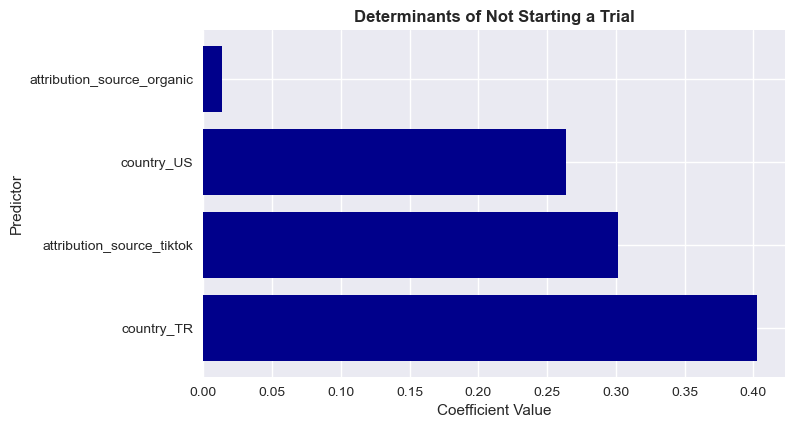

In [24]:
coefficients = model_boot.coef_[0]
predictor_names = X_encoded.columns

coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(7.5, 4.5))
plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color = 'darkblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.title('Determinants of Not Starting a Trial', fontweight = 'bold')
plt.show()

Our logistic regression model output shows that being from Turkey sizably increases the odds of failing to start a trial run compared to the Netherlands and the US, while having an organic attribution source seems to have little to no effect compared to users from Instagram. Recalling that Mr. Kent is from Turkey, he is at a relatively higher risk.

### 7.B. Trial-to-Subscription

For this step, we will subset the users who initiated their trial run to see the odds of Clark Kent starting his subscription **provided that** he has started his trial run.

In [25]:
test2 = novo_sum[novo_sum['trial'] == 1]

Then we will replicate our previous strategy by using a new dummy on transitioning to paid subscription as the outcome variable.

In [26]:
test2['fail_to_subscribe'] = np.where(test2['subscription'] == 0, 1, 0)

X = test2[['country', 'attribution_source']]
y = test2['fail_to_subscribe']

# Turning our categorical predictors into dummies for the training:
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Set seed for reproducability:
np.random.seed(42)

n_bootstraps = 1000
boot_preds = []

for _ in range(n_bootstraps):
    # Resample data with replacement
    X_resampled = X_train.sample(frac=1, replace=True, random_state=np.random.randint(10000))
    y_resampled = y_train.loc[X_resampled.index]

    # Train a new model on resampled data
    model_boot = LogisticRegression()
    model_boot.fit(X_resampled, y_resampled)

    # Predict probability for the new customer
    boot_preds.append(model_boot.predict_proba(clark_kent)[:, 1][0])

# Compute confidence intervals
lower_bound = np.percentile(boot_preds, 2.5)
upper_bound = np.percentile(boot_preds, 97.5)

nosubscription_probability = model_boot.predict_proba(clark_kent)[:, 1]


/var/folders/h0/v4b0bs811x35xjk82g1h9bg00000gn/T/ipykernel_14746/2784614107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['fail_to_subscribe'] = np.where(test2['subscription'] == 0, 1, 0)


Making his odds of starting the subscription **if** he has used a trial run:

In [27]:
print(f"No Subscription Probability: {nosubscription_probability[0]:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

No Subscription Probability: 0.40
95% Confidence Interval: [0.24, 0.41]


Visualizing the determinants of not starting subscription upon the trial period:

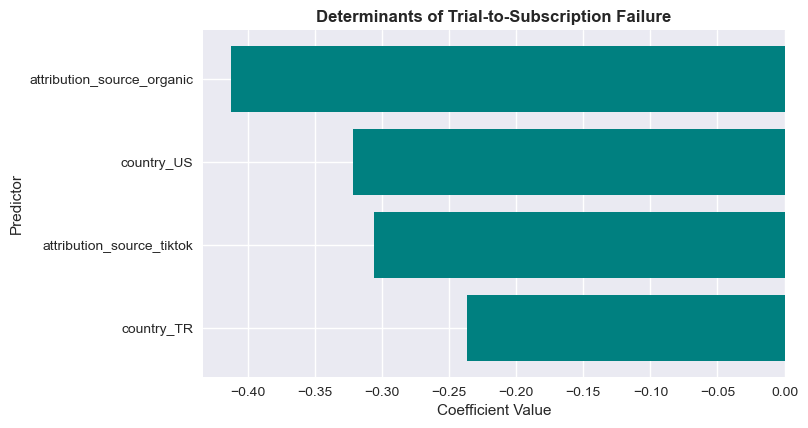

In [28]:
coefficients = model_boot.coef_[0]
predictor_names = X_encoded.columns

coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(7.5, 4.5))
plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color = 'teal')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.title('Determinants of Trial-to-Subscription Failure', fontweight = 'bold')
plt.show()

This output shows that being from Turkey (where Mr. Kent is from) has a positive effect on increasing the chance of continuing with subscription after trial, and users with organic attribution sources are also much less likely to drop out of the path toward subscription. These figures do not address why we still observe a fairly high chance of churn (0.4) and call for more parameters to include (age, gender, other relevant user data).

### 7.C. Churn as a Subscriber

At this latest stage, we will subset those users who started their subscription and create a new binary outcome variable based on whether they cancelled their subscription.

In [29]:
test3 = novo_sum[novo_sum['subscription'] == 1]
test3

X = test3[['country', 'attribution_source']]
y = test3['cancellation']

# Turning our categorical predictors into dummies for the training:
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

###

# Set seed for reproducability:
np.random.seed(42)

n_bootstraps = 1000
boot_preds = []


for _ in range(n_bootstraps):
    
    X_resampled = X_train.sample(frac=1, replace=True, random_state=np.random.randint(10000))
    y_resampled = y_train.loc[X_resampled.index]

    
    model_boot = LogisticRegression()
    model_boot.fit(X_resampled, y_resampled)

    
    boot_preds.append(model_boot.predict_proba(clark_kent)[:, 1][0])


lower_bound = np.percentile(boot_preds, 2.5)
upper_bound = np.percentile(boot_preds, 97.5)

cancellation_probability = model_boot.predict_proba(clark_kent)[:, 1]

Making Mr. Kent's likelihood to cancel his subscription **as a subscriber**:

In [30]:
print(f"Cancellation Probability: {cancellation_probability[0]:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

Cancellation Probability: 0.67
95% Confidence Interval: [0.65, 0.83]


Visualizing the determinants of churn as among subscribers:

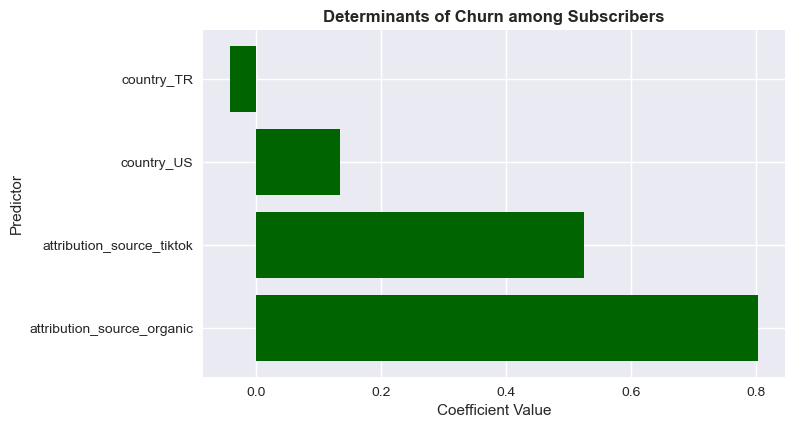

In [31]:
coefficients = model_boot.coef_[0]
predictor_names = X_encoded.columns

coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(7.5, 4.5))
plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color = 'darkgreen')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.title('Determinants of Churn among Subscribers', fontweight = 'bold')
plt.show()

We see that although the Turkish subscribers are slightly less likely to drop out of their subscription plan, having an organic attribution source makes it more likely to do so compared to customers from Instagram and Tiktok, explaining why Mr. Kent's estimated churn probability at the last stage is quite high (0.67).

This 3-stage analysis allows us to see that **the churn probabilities and their determinants differ by each stage**: although Mr. Kent's odds of churning through not starting a trial is quite low (around 0.24), his probability of not transitioning to paid transcription is fairly high (0.4) and eventually, his likelihood to stop renewing his subscription is very likely (0.67).

## 8. Potential Lifetime Value for Bruce Wayne

In [32]:
merged_df[merged_df['name'] == 'Bruce Wayne']

,user_id,account_created,attribution_source,country,name,acquisition_channel,id,created_at,event_name,amount_usd,trialer,subscriber
3482,1001,2025-02-16T00:00:00,instagram,US,Bruce Wayne,None,3483,2025-02-25T00:00:00,app_install,NaN,0,0
3483,1001,2025-02-16T00:00:00,instagram,US,Bruce Wayne,None,3484,2025-02-25T00:00:00,trial_started,NaN,1,0
3484,1001,2025-02-16T00:00:00,instagram,US,Bruce Wayne,None,3485,2025-02-25T00:00:00,subscription_started,9.99,0,1


We see that Bruce is an American customer who has just started his subscription. Hence, estimating his potential lifetime value should be based on a model drawing on a sample of subscribers. Let's replicate our previous subsetting process while excluding Bruce from the new subset.

In [33]:
subscribers = subscribers[subscribers.index != 1001]
subscribers

,country,duration,attribution_source,amount,lifetime_value
user_id,,,,,
2,NL,4,instagram,8.99,35.96
3,TR,4,tiktok,4.99,19.96
8,TR,2,tiktok,4.99,9.98
9,US,2,organic,9.99,19.98
10,US,2,organic,9.99,19.98
...,...,...,...,...,...
991,TR,4,organic,4.99,19.96
992,US,5,instagram,9.99,49.95
995,US,3,instagram,9.99,29.97


We can now train our Poisson model where lifetime value is the outcome variable. As in previous models, I will use bootstrapped standard errors to get more reliable confidence intervals.

In [34]:
from sklearn.linear_model import LinearRegression

subscribers['lifetime_value'] = pd.to_numeric(subscribers['lifetime_value'], errors='coerce')
subscribers.dropna(subset=['lifetime_value'], inplace=True) #remove NaN values.

X = subscribers[['country', 'attribution_source']]
y = subscribers['lifetime_value']

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

bruce_wayne = merged_df[(merged_df['name'] == 'Bruce Wayne') & (merged_df['event_name'] == 'subscription_started')]
bruce_wayne = bruce_wayne[['country', 'attribution_source']]

bruce_wayne_encoded = pd.get_dummies(bruce_wayne, drop_first=True).reindex(columns=X_encoded.columns, fill_value=0)

np.random.seed(42)
n_bootstraps = 1000
boot_preds = []

for _ in range(n_bootstraps):
    X_resampled = X_train.sample(frac=1, replace=True)
    y_resampled = y_train.loc[X_resampled.index]

    model_boot = LinearRegression()  # Use LinearRegression
    model_boot.fit(X_resampled, y_resampled)

    boot_preds.append(model_boot.predict(bruce_wayne_encoded)[0])

lower_bound = np.percentile(boot_preds, 2.5)
upper_bound = np.percentile(boot_preds, 97.5)

predicted_ltv = model_boot.predict(bruce_wayne_encoded)

print(f"Potential Lifetime Value: {predicted_ltv[0]:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

/var/folders/h0/v4b0bs811x35xjk82g1h9bg00000gn/T/ipykernel_14746/608695417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers['lifetime_value'] = pd.to_numeric(subscribers['lifetime_value'], errors='coerce')
/var/folders/h0/v4b0bs811x35xjk82g1h9bg00000gn/T/ipykernel_14746/608695417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers.dropna(subset=['lifetime_value'], inplace=True) #remove NaN values.


Potential Lifetime Value: 24.59
95% Confidence Interval: [20.26, 24.85]


Like in our previous analyses, we can visualize the determinants of the results and their coefficient strengths. 

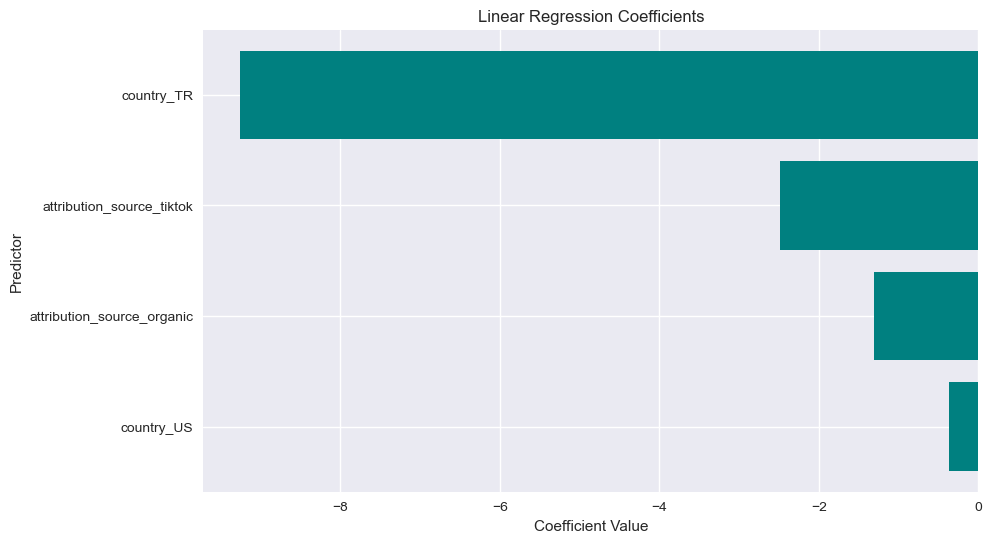

In [35]:
coefficients = model_boot.coef_
predictor_names = X_encoded.columns

coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Predictor'], coef_df['Coefficient'], color = 'teal')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.title('Linear Regression Coefficients') 
plt.show()

These results show that compared to the Netherlands, being from the US decreases the lifetime value slightly, while coming from tiktok or having an organic attribution source is associated with a much sharper decrease as opposed to Instagram as an attribution source.